In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from torch.optim import SGD
from torch.utils.data import random_split, DataLoader
from imutils import paths
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
def normalizeAndProcessing(img: np.ndarray):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0, ), (1.0, ))])
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resize_img = cv2.resize(gray_img, (28, 28))
    vector = transform(resize_img)
    return vector

In [4]:
def getData(list_dir, threshold):
    data = []
    i = 0
    for img_path in list_dir:
        label_img = img_path.split(os.path.sep)[-1]
        label_img = label_img.split('.')[0]
        if label_img == 'cat': label_img = 0.0
        else: label_img = 1.0
        img = cv2.imread(img_path)
        normalize_img = normalizeAndProcessing(img)
        data.append([normalize_img, torch.tensor([label_img], dtype = torch.float32)])
        i += 1
        if i == threshold: break
    return data

In [5]:
path_train = 'D:\\dogs-vs-cats\\train'
path_test = 'D:\\dogs-vs-cats\\test1'
list_dir_train = list(paths.list_images(path_train))
list_dir_test = list(paths.list_images(path_test))
train_dataset = getData(list_dir_train, 25000)
train_size = 0.6
test_size = 0.4
training, validation = random_split(train_dataset, [train_size, test_size])
batch_size = 1024
train_dataloader = DataLoader(training, batch_size = batch_size, shuffle  = True)
test_dataloader = DataLoader(validation, batch_size = batch_size, shuffle = True)

In [7]:
class LogisticRegression(nn.Module):
    def __init__(self, n_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_features, 1)
        ).to(device)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [9]:
n_features = 784
model = LogisticRegression(n_features = n_features)
img = cv2.imread(list_dir_test[10])

new_img = normalizeAndProcessing(img)

criterion = nn.BCELoss()
res = model(new_img)
print(res)
loss = criterion(res, torch.tensor([[0.0]]))
print(loss)
optimizer = SGD(model.parameters(), lr = 0.01)

tensor([[0.3988]], grad_fn=<SigmoidBackward0>)
tensor(0.5088, grad_fn=<BinaryCrossEntropyBackward0>)


In [10]:
max_epochs = 300
train_losses, test_losses, test_accuracy = [], [], []

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0
    total = 0.0
    correct = 0.0
    for img, label in train_dataloader:
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, label)
        train_loss += loss.item() * img.size(0)
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    # Evaluate model
    model.eval()
    test_loss = 0.0
    total = 0.0
    correct = 0.0
    with torch.no_grad():
        for img, label in test_dataloader:
            outputs = model(img)
            loss = criterion(outputs, label)
            test_loss += loss.item() * img.size(0)
            y_hat = (outputs >= 0.5).float()
            total += label.size(0)
            correct += (y_hat == label).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    # print(correct, total)
    accuracy = correct / total
    test_accuracy.append(accuracy)
    print(f'Epoch {epoch + 1}/{max_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/300, Train Loss: 0.6968, Test Loss: 0.6943, Test Accuracy: 0.5055
Epoch 2/300, Train Loss: 0.6936, Test Loss: 0.6931, Test Accuracy: 0.5105
Epoch 3/300, Train Loss: 0.6924, Test Loss: 0.6914, Test Accuracy: 0.5254
Epoch 4/300, Train Loss: 0.6912, Test Loss: 0.6904, Test Accuracy: 0.5380
Epoch 5/300, Train Loss: 0.6907, Test Loss: 0.6897, Test Accuracy: 0.5356
Epoch 6/300, Train Loss: 0.6900, Test Loss: 0.6894, Test Accuracy: 0.5322
Epoch 7/300, Train Loss: 0.6891, Test Loss: 0.6891, Test Accuracy: 0.5318
Epoch 8/300, Train Loss: 0.6885, Test Loss: 0.6885, Test Accuracy: 0.5343
Epoch 9/300, Train Loss: 0.6879, Test Loss: 0.6869, Test Accuracy: 0.5504
Epoch 10/300, Train Loss: 0.6873, Test Loss: 0.6865, Test Accuracy: 0.5590
Epoch 11/300, Train Loss: 0.6870, Test Loss: 0.6860, Test Accuracy: 0.5567
Epoch 12/300, Train Loss: 0.6866, Test Loss: 0.6855, Test Accuracy: 0.5592
Epoch 13/300, Train Loss: 0.6861, Test Loss: 0.6851, Test Accuracy: 0.5590
Epoch 14/300, Train Loss: 0.6858, 

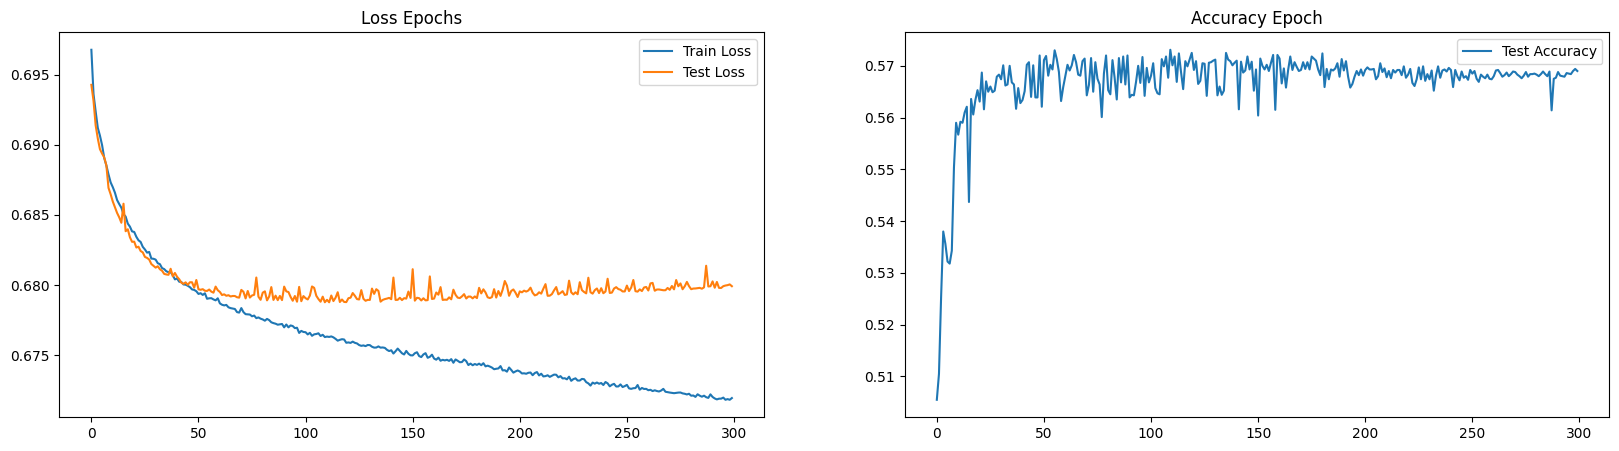

In [11]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracy, label = 'Test Accuracy')
plt.legend()